In [13]:
from sklearn import preprocessing
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import pandas as pd
import matplotlib as plt

In [14]:
#LOADING dataset
filename = 'dataset/BTC-USD.csv'
data = pd.read_csv(filename)
print( "DataFrame has shape of ", data.shape )

DataFrame has shape of  (1827, 7)


In [15]:
data.head(5)

,Date,Open,High,Low,Close,Adj Close,Volume
0,2016-12-20,792.247009,801.336975,791.497009,800.875977,800.875977,99629296
1,2016-12-21,800.643982,834.281006,799.405029,834.281006,834.281006,155576000
2,2016-12-22,834.179993,875.781982,834.148987,864.539978,864.539978,200027008
3,2016-12-23,864.888000,925.117004,864.677002,921.984009,921.984009,275564000
4,2016-12-24,922.179993,923.479004,886.335022,898.822021,898.822021,137727008


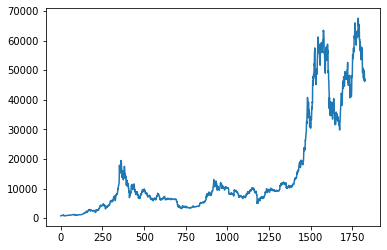

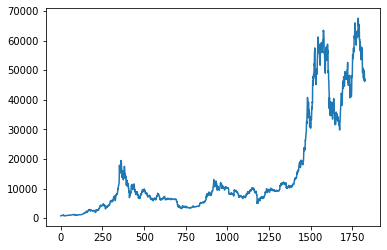

In [16]:
data["Close"].plot().get_figure()

1643/1827 data points remain.


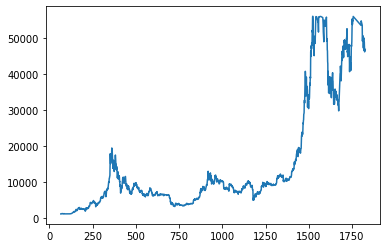

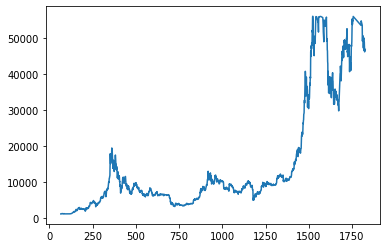

In [17]:
data_editing=data["Close"]
removed_outliers = data_editing.between(data_editing.quantile(.05), data_editing.quantile(.95))
print(str(data_editing[removed_outliers].shape[0]) + "/" + str(data.shape[0]) + " data points remain.")
data_editing[removed_outliers].plot().get_figure()

In [18]:
index_names = data[~removed_outliers].index # INVERT removed_outliers!!
data.drop(index_names, inplace=True)
data.head(5)

,Date,Open,High,Low,Close,Adj Close,Volume
66,2017-02-24,1172.709961,1200.390015,1131.959961,1173.680054,1173.680054,330759008
69,2017-02-27,1163.780029,1181.979980,1163.380005,1179.969971,1179.969971,131570000
70,2017-02-28,1180.719971,1193.250000,1171.819946,1179.969971,1179.969971,184956000
71,2017-03-01,1180.040039,1222.500000,1179.689941,1222.500000,1222.500000,229056992
72,2017-03-02,1224.680054,1262.130005,1215.619995,1251.010010,1251.010010,368275008


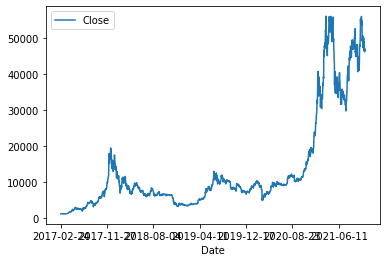

In [19]:
#VISUALISATION of the dataset
#as time series
data.plot.line(y="Close", x="Date")
plt.pyplot.show()

In [20]:
#as a linear function
d=data.to_numpy()
X = data[ ["Close"] ].to_numpy()#as_matrix()
y = data[ ["Open", "High", "Low", "Volume"] ].to_numpy()
print( X.shape, y.shape )

(1643, 1) (1643, 4)


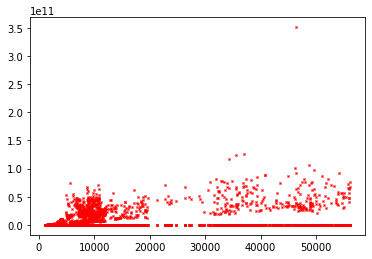

In [21]:
plt.pyplot.plot( X, y, 'rx', markersize=2 )
plt.pyplot.show()

In [22]:
#PREPROCESSING
#normalisation
scaler = preprocessing.MinMaxScaler()
names =["Open", "High", "Low", "Volume", "Close"]
data = scaler.fit_transform(data[names])
data = pd.DataFrame(data, columns=names)
data.head()


,Open,High,Low,Volume,Close
0,0.000970,0.000310,0.000287,0.000568,0.000021
1,0.000816,0.000000,0.000864,0.000000,0.000136
2,0.001107,0.000190,0.001019,0.000152,0.000136
3,0.001096,0.000683,0.001163,0.000278,0.000910
4,0.001863,0.001350,0.001822,0.000675,0.001429


In [23]:
data_close= data[["Close"]] #needed in order to preserve the actual close value per day
data_close= data_close.rename(columns = {'Close':'Actual_Close'})
#rolling over every two rows, check if the later close value is greater than the preceding one and return 1, otherwise 0
data_close["Target"] = data.rolling(2).apply(lambda x: x.iloc[1] > x.iloc[0])["Close"]
data_close.head()

,Actual_Close,Target
0,0.000021,NaN
1,0.000136,1.0
2,0.000136,0.0
3,0.000910,1.0
4,0.001429,1.0


In [24]:
#ensure that the prediction of future prices depends on past data
data_prev = data.copy()
data_prev = data_prev.shift(1)
data_prev.head()

,Open,High,Low,Volume,Close
0,NaN,NaN,NaN,NaN,NaN
1,0.000970,0.000310,0.000287,0.000568,0.000021
2,0.000816,0.000000,0.000864,0.000000,0.000136
3,0.001107,0.000190,0.001019,0.000152,0.000136
4,0.001096,0.000683,0.001163,0.000278,0.000910


In [25]:
# Create training data
predictors = ["Volume", "Open", "High", "Low"]
data_close = data_close.join(data_prev[predictors]).iloc[1:]
data_close.head()

,Actual_Close,Target,Volume,Open,High,Low
1,0.000136,1.0,0.000568,0.000970,0.000310,0.000287
2,0.000136,0.0,0.000000,0.000816,0.000000,0.000864
3,0.000910,1.0,0.000152,0.001107,0.000190,0.001019
4,0.001429,1.0,0.000278,0.001096,0.000683,0.001163
5,0.001866,1.0,0.000675,0.001863,0.001350,0.001822


In [26]:
#TRAINING
lin_reg = LinearRegression()
x_train, x_test,y_train,  y_test= train_test_split(data_close[predictors], data_close["Actual_Close"])
lin_reg.fit(x_train, y_train)

# Evaluate error of predictions
r_sq = lin_reg.score(x_train, y_train)
print('Linear Regression: coefficient of determination:', r_sq)
print('Linear Regression: intercept:', lin_reg.intercept_) #tells how much our model predicts the response when 𝑥_train is zero
print('Linear Regression: slope:', lin_reg.coef_)

Linear Regression: coefficient of determination: 0.9955601391781003
Linear Regression: intercept: 0.0009111530114895294
Linear Regression: slope: [ 0.01608226 -0.51170962  0.9728542   0.56451413]
